<a href="https://colab.research.google.com/github/team9team9/tabby-or-not/blob/main/Group9Beojji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_direction='/content/drive/MyDrive/Dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch
from torch.utils.data import random_split, DataLoader
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import StepLR

In [ ]:
#mahirah's part

transform=transforms.Compose([ transforms.Resize((224,224)), transforms.ToTensor()])

dataset= datasets.ImageFolder(root=data_direction,transform=transform)
dataloader= DataLoader(dataset, batch_size=8, shuffle=True)

print("Classes: ", dataset.classes)
print("Total Imagest: ", len(dataset))

#splitting into train, valid, test using 8:1:1

total_size=len(dataset) #160 images
train_size=int(0.8*total_size) #128
valid_size=int(0.1*total_size) #16
test_size=total_size-train_size-valid_size #16

print(f'\nTrain size: {train_size}')
print(f'Valid size: {valid_size}')
print(f'Test size: {test_size}')

#random split
train_dataset, val_dataset, test_dataset= random_split(dataset, [train_size, valid_size, test_size])

#create dataloaders to give model data in clean, shuffled batches
# these is used for training part / inference
train_loader=DataLoader(train_dataset, batch_size=8, shuffle=True) #use for train (train acc)
valid_loader=DataLoader(val_dataset, batch_size=8, shuffle=True) #use to evaluate model during training (val acc)
test_loader=DataLoader(test_dataset, batch_size=8, shuffle=True) #use to evaluate model AFTER training (final testing or inference)


Classes:  ['Not_Tabby', 'Tabby']
Total Imagest:  160

Train size: 128
Valid size: 16
Test size: 16


In [ ]:
# CNN using resnet as backbone and with new dense layer to get the weight and loss during training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CNN(nn.Module):
    def __init__(self, num_classes=2): #for binary classifiaction
        super().__init__()
        base=models.resnet18(pretrained=True) #load resnet18 with pretrained weights from imagenet
        #resnet is strong extracting features from images
        self.features = nn.Sequential(*list(base.children())[:-1])
        # remove the last layer of original resnet classifier so only convo backbone of resnet
        self.classifier=nn.Linear(512, num_classes)  #outputs a 512 dime feature vector for each image
        # add new dense / fc to do the binary classification
        # self.classifier takes the output from resnet backbone and outputs 2 values for each label (class)
        # and this is logits (raw scores) for each class which then passed to crossentropyloss which then convert into prob

    def forward(self, x):
        x=self.features(x) #extract deep features
        x = x.view(x.size(0), -1)
        #flatten from B,512,1,1 to B,512
        return self.classifier(x) #predict class scores


In [ ]:
#training CNN
model=CNN(num_classes=2).to(device)

#loss fucntion for multi-class classification
criterion=nn.CrossEntropyLoss()
#adam is the best one currently, and used ofr updating weights
optimizer=optim.Adam(model.parameters(),lr=0.001)
#reduce lr by multiply by 0.1 every 5 epochs to help fine tuning gently
scheduler=StepLR(optimizer,step_size=5,gamma=0.1)


train_losses = []# to plot loss graph
val_losses =[]

best_val_acc = 0.0 #track best val acc for best_model.pth
best_train_loss =float('inf')


# training loop
num_epochs=10
for epoch in range(num_epochs):
    model.train() # enable dropout/batchnorm for training behaviour
    total_loss=0.0
    correct=0
    total = 0

    for images,labels in train_loader:#train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
        images,labels =images.to(device), labels.to(device)

# backprop compute output-> compute loss-> backprop-> update weight
        optimizer.zero_grad()
        outputs =model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() #accumulate loss

        #to get predicted class index for each sample in bacth
        # find mac value and index
        _, predicted = torch.max(outputs, 1)
        total+=labels.size(0)

        correct+=(predicted==labels).nonzero().size(0)#counting how many pred are correct in batch

    # calculate avg loss and training acc
    avg_loss = total_loss/len(train_loader)



    train_acc = correct/total
    train_losses.append(avg_loss)
    scheduler.step()

    # save model if training loss is lowest
    if avg_loss < best_train_loss:
        best_train_loss = avg_loss
        torch.save(model.state_dict(), "best_model_train.pth")
        print(f"Saved new best model with Train Loss: {avg_loss:.4f}")

#track how lr reduced
    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']
    print(f"Learning Rate: {current_lr}")


    # to find validation accuracy for generalization
    # this to see if our model can generalize
    # because if we only use train acc, it might be overfitting
    model.eval() #use eval
    correct=0
    total= 0
    total_valloss=0.0

    with torch.no_grad(): #no gradient
        for val_images, val_labels in valid_loader:

          #same implementation as training but this one, model dont do the backprop, weight update, no model.train
          # this is only for validation accuracy

            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            loss = criterion(val_outputs, val_labels) #calculate val losses
            total_valloss += loss.item() #accumulate val loss
            _, val_preds = torch.max(val_outputs, 1)
            total += val_labels.size(0)
            correct += (val_preds == val_labels).nonzero().size(0)

    val_acc=correct/total
    avg_valloss = total_valloss/len(valid_loader)
    val_losses.append(avg_valloss)

    # save the best model based on validation accuracy
    if val_acc>best_val_acc:
        best_val_acc=val_acc
        torch.save(model.state_dict(), "best_model_valacc.pth")
        print(f"Saved new best model with Val Acc: {val_acc:.2f}")

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f} | Val Acc: {val_acc:.2f}")


Saved new best model with Train Loss: 0.7425
Learning Rate: 0.001
Saved new best model with Val Acc: 0.44
Epoch 1/10 | Loss: 0.7425 | Train Acc: 0.78 | Val Acc: 0.44
Saved new best model with Train Loss: 0.4612
Learning Rate: 0.001
Saved new best model with Val Acc: 0.56
Epoch 2/10 | Loss: 0.4612 | Train Acc: 0.84 | Val Acc: 0.56
Saved new best model with Train Loss: 0.3177
Learning Rate: 0.001
Saved new best model with Val Acc: 0.94
Epoch 3/10 | Loss: 0.3177 | Train Acc: 0.91 | Val Acc: 0.94
Saved new best model with Train Loss: 0.2118
Learning Rate: 0.001
Epoch 4/10 | Loss: 0.2118 | Train Acc: 0.94 | Val Acc: 0.88
Saved new best model with Train Loss: 0.1488
Learning Rate: 0.0001
Saved new best model with Val Acc: 1.00
Epoch 5/10 | Loss: 0.1488 | Train Acc: 0.95 | Val Acc: 1.00
Saved new best model with Train Loss: 0.1480
Learning Rate: 0.0001
Epoch 6/10 | Loss: 0.1480 | Train Acc: 0.95 | Val Acc: 0.94
Saved new best model with Train Loss: 0.0859
Learning Rate: 0.0001
Epoch 7/10 | Lo

In [ ]:
state_dict = torch.load("best_model_train.pth")

with open("beojji_weights.txt", "w") as f:
    for name, param in state_dict.items():
        f.write(f"{name}: {param.shape}\n")
        f.write(str(param.cpu().numpy()))  # write all weights
        f.write("\n\n")

In [ ]:
from google.colab import files
files.download("beojji_weights.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

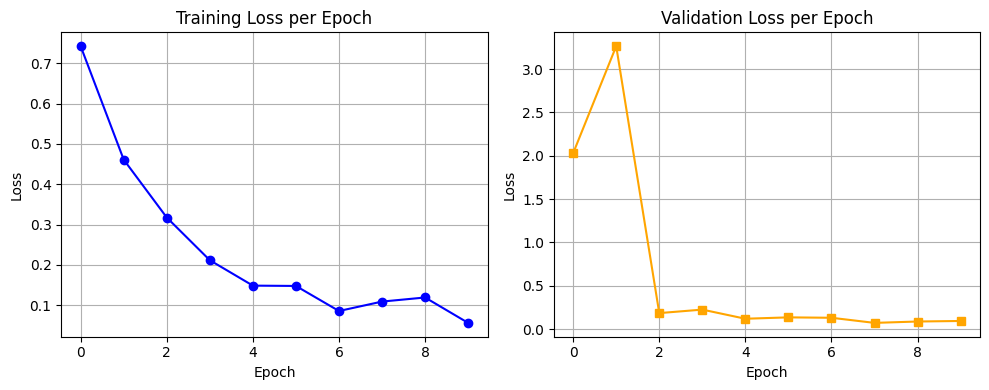

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o', color='blue')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_losses, marker='s', color='orange')
plt.title("Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# load best model from cnn and remove the classifier
model3=CNN(num_classes=2).to(device)
model3.load_state_dict(torch.load("best_model_train.pth"))
model3.eval()

#extract just the feature extractor part from cnn
#cnn model but wihtout dense layer
feature_extractor=model3.features


In [ ]:
import numpy as np

#using the traiend CNN model as feature_extractor

def extract_features(dataloader):
    features=[]
    labels=[]#loop thru dataset train/va/test-> pass trhu cnn-> collect output features

    with torch.no_grad():#no gradients are needed bcz we are not training
# x is images and y is the labels
        for x, y in dataloader:
            x=x.to(device)
            f=feature_extractor(x) #f is the output in tensor of shape b,c,h,w
            f=f.view(f.size(0),-1) # flatten feature maps to (32, 512)
            features.append(f.cpu().numpy())# now image is a 1D vector of length 512
            labels.append(y.numpy())

    return np.vstack(features),np.concatenate(labels)
    #np.vstack stacks all feature vectors vertically into shape N,F where n = total images
    #both fucntion learned from https://numpy.org/doc/2.1/reference/generated/numpy.vstack.html

train_features,train_labels=extract_features( train_loader)
val_features, val_labels=extract_features(valid_loader)
test_features,test_labels=extract_features(test_loader)

##💥 KNN Classification (Fine-tuning K)

**Purpose:**
To train a K-Nearest Neighbors (KNN) classifier to distinguish between Tabby and other cats based on the extracted features.

**Approach:**

1. We train KNN models with k values of 3, 5, and 7.
2. Accuracy is measured on the validation set to determine the best k.
3. The best-performing KNN model is retrained on the full training set.

### 📌 Evaluation Metrics

- **Accuracy**: $$\frac{TP + TN}{TP + TN + FP + FN}$$

- **Precision**: $$\frac{TP}{TP + FP}$$

- **Recall**: $$\frac{TP}{TP + FN}$$

- **F1-score**: $$2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$

In [ ]:
# fine tune k using val_dataset
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

best_k = None
best_acc = 0

for k in [3,5,9]:
  # train to find the best k using extracted features from cnn
  knn=KNeighborsClassifier(n_neighbors=k)
  knn.fit(train_features, train_labels)  # only train set
  val_preds=knn.predict(val_features)
  val_acc=accuracy_score(val_labels, val_preds)
  print(f"K = {k}, Validaltion Accuracy = {val_acc:.2f}")

  if val_acc>best_acc:
    best_acc = val_acc
    best_k = k

print(f"Best k = {best_k}, Best Accuracy = {best_acc:.2f}")



K = 3, Validaltion Accuracy = 1.00
K = 5, Validaltion Accuracy = 1.00
K = 9, Validaltion Accuracy = 0.94
Best k = 3, Best Accuracy = 1.00


In [ ]:
# mahirah's KNN

# retrain KNN using best_k after fine tuning va_dataset
knn=KNeighborsClassifier(n_neighbors=best_k)
knn.fit(train_features, train_labels)

#predict on the test features
preds=knn.predict(test_features)

In [ ]:
# mahirah's evaluation

print(f'Accuracy: ', accuracy_score(test_labels, preds))
print(f'Confusion Matrix: \n', confusion_matrix(test_labels, preds))
print(f'Classification Report: \n', classification_report(test_labels, preds))

Accuracy:  1.0
Confusion Matrix: 
 [[ 5  0]
 [ 0 11]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        11

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



##👉 Prediction on New Image + Similarity to Tabby

**Purpose:**
To classify a new, unseen image as Tabby or Not Tabby, and compute a similarity score (% resemblance) to Tabby.

**Approach:**


1. A new image is preprocessed and passed through the CNN to get its feature vector.
2. KNN is used to predict the class label.
3. Cosine similarity is computed between the image’s feature vector and the average feature vector of known Tabby images.
4. Results are visualized with the image and prediction displayed.

### 📌 Cosine Similarity

To compute how similar a new image is to TAbby, we use cosine similarity:

$$\text{CosineSimilarity}(A, B) = \frac{A \cdot B}{\|A\| \cdot \|B\|}$$

Where:
- \(A\) is the feature vector of the input image
- \(B\) is the average feature vector of known Tabby images


In [ ]:
# testing with new image
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

tabby_mean = train_features[train_labels == 1].mean(axis=0).reshape(1, -1)


def predict_image(img_path, feature_extractor, knn, device, class_names, tabby_mean):
  model.eval() # inference mode for new unseen data
  # so .eval -> no dropping and freeze stats. it is like no more learning, just 'answering' or 'predicting'

  img=Image.open(img_path).convert('RGB')
  img=transforms.Resize((224,224))(img) #tomaintain same size dur training


  #convert image to tensor (shape 3,224,224) using transforms,ToTensor
  img_tensor=transforms.ToTensor()(img).unsqueeze(0).to(device)
  # learn and understand this function trhu https://docs.pytorch.org/vision/0.8/transforms.html
  # basically ToTensor will normalize our pixel value to float point number between 0 to 1
  # unsqueeze(0) is used to add a batch dimension because (in pytorch) all models expect input in batches format so
  # instead like one image [3,224,224], model expects [1,3,224,224]

  # extract feature from cnn, no gradients needed
  with torch.no_grad(): # bcz we arent traning and thus can save memory, referring https://docs.pytorch.org/docs/stable/generated/torch.no_grad.html
    features = feature_extractor(img_tensor) #get feature from cnn's fc1 to be used for knn
    features = features.view(features.size(0), -1)
    features_np = features.cpu().numpy()




# since knn use numpy, we have to convert features tensor to numpy array
  pred = knn.predict(features_np)[0]
  pred_class=class_names[pred]
  similarity = cosine_similarity(features_np, tabby_mean)[0][0] * 100

  plt.imshow(img)
  plt.axis('off')
  plt.title(f'Prediction: {pred_class}\nSimilarity to Tabby: {similarity:.2f}%')
  plt.show()

  return pred_class, similarity


In [ ]:
from google.colab import files
uploaded = files.upload()
!ls

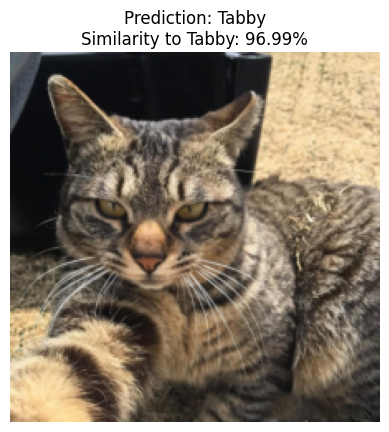

('Tabby', np.float32(96.9885))

In [ ]:
predict_image("IMG_1.jpg", feature_extractor, knn, device, dataset.classes, tabby_mean)

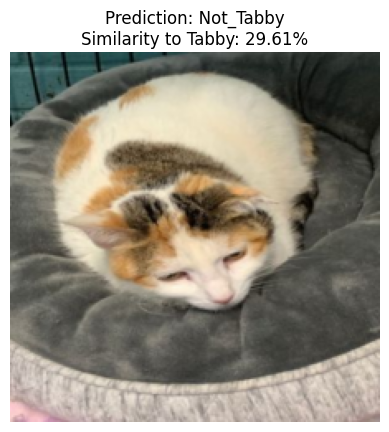

('Not_Tabby', np.float32(29.6101))

In [ ]:
predict_image("IMG_2.jpg", feature_extractor, knn, device, dataset.classes, tabby_mean)

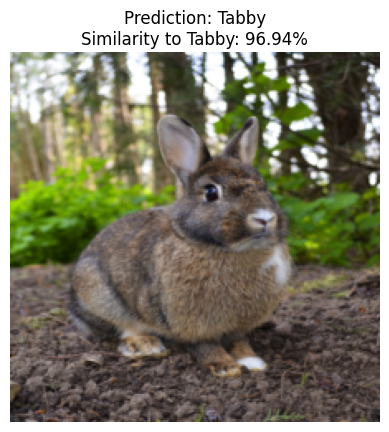

('Tabby', np.float32(96.94441))

In [ ]:
predict_image("IMG_3.jpg", feature_extractor, knn, device, dataset.classes, tabby_mean)

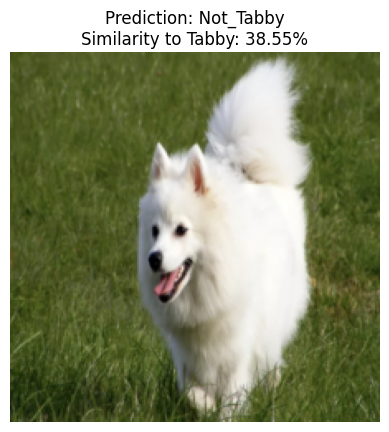

('Not_Tabby', np.float32(38.54695))

In [ ]:
predict_image("IMG_4.jpeg", feature_extractor, knn, device, dataset.classes, tabby_mean)

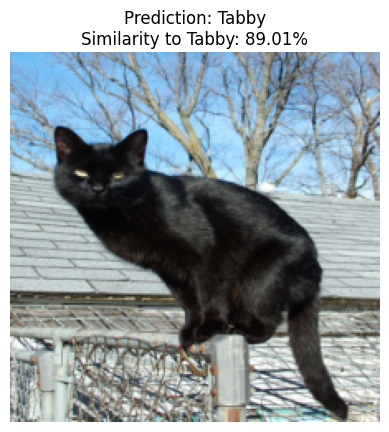

('Tabby', np.float32(89.00979))

In [ ]:
predict_image("IMG_5.jpg", feature_extractor, knn, device, dataset.classes, tabby_mean)

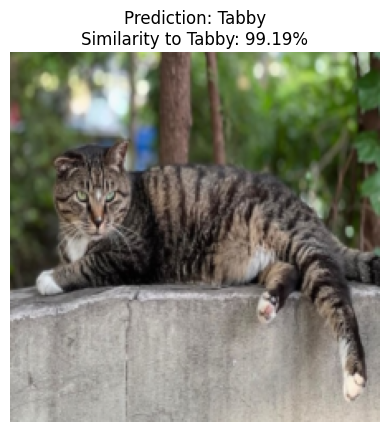

('Tabby', np.float32(99.18926))

In [ ]:
predict_image("IMG_6.jpg", feature_extractor, knn, device, dataset.classes, tabby_mean)

In [ ]:
# predicting wether Tabby is going to be at his hoouse or not using random tree

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#from sklearn.tree import export_text


df = pd.read_csv('/content/drive/MyDrive/Dataset/beojji_dataset2.csv')

df = pd.get_dummies(df, columns=['season', 'time_of_day', 'is_raining', 'noise_level'])

X = df.drop('home_or_not', axis=1)
y = df['home_or_not']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model2 = RandomForestClassifier(n_estimators=25, random_state=42)
model2.fit(X_train, y_train)

y_pred_test = model2.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy: ", test_accuracy)

#print(export_text(model.estimators_[0], feature_names=list(X_encoded.columns)))



Test Accuracy:  0.9333333333333333


In [ ]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def tabby_predict():

  input_data = {col: 0 for col in X.columns}

  season = input("Season (spring/summer/autumn/winter): ").strip().lower()
  input_data[f'season_{season}'] = 1

  time = input("Time of day (morning/evening/night): ").strip().lower()
  input_data[f"time_of_day_{time}"] = 1

  is_raining = int(input("Is it raining? (yes=1, no=0): "))
  input_data[f"is_raining_{is_raining}"] = 1

  noise = input("Noise level (low/medium/high)): ")
  input_data[f'noise_level_{noise}'] = 1

  input_vector = [input_data.get(col,0) for col in X.columns]
  pred = model2.predict([input_vector])[0]

  if pred == 1:
    print("Tabby is likely at his house.")
  else:
    print("Tabby is probably out and about.")

tabby_predict()

Season (spring/summer/autumn/winter): summer
Time of day (morning/evening/night): night
Is it raining? (yes=1, no=0): 1
Noise level (low/medium/high)): high
Tabby is probably out and about.


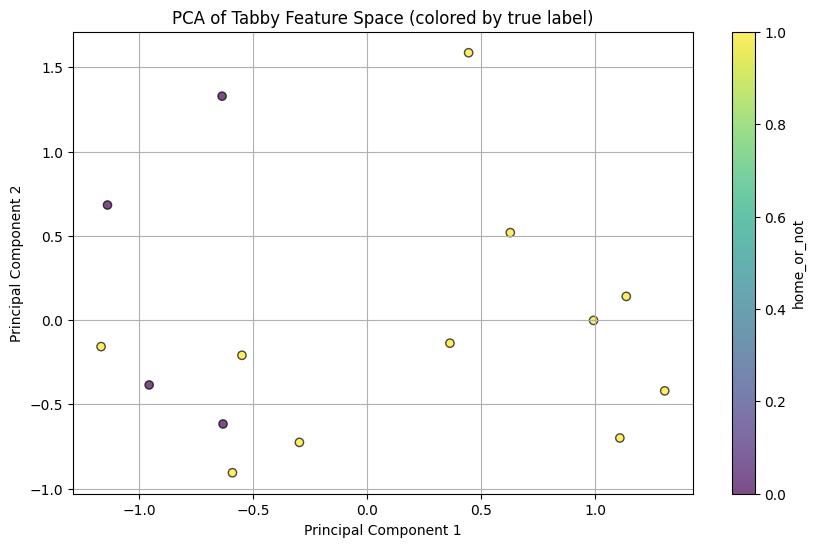

In [ ]:
# visualization using PCA

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test)

y_pred = model2.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap='viridis', alpha=0.7, edgecolors='k')
plt.title('PCA of Tabby Feature Space (colored by true label)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='home_or_not')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.tree import export_text

tree_rules = export_text(model2.estimators_[0], feature_names=list(X.columns))
print(tree_rules)


|--- is_raining_1 <= 0.50
|   |--- time_of_day_evening <= 0.50
|   |   |--- class: 1.0
|   |--- time_of_day_evening >  0.50
|   |   |--- season_autumn <= 0.50
|   |   |   |--- noise_level_medium <= 0.50
|   |   |   |   |--- class: 1.0
|   |   |   |--- noise_level_medium >  0.50
|   |   |   |   |--- season_spring <= 0.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- season_spring >  0.50
|   |   |   |   |   |--- class: 0.0
|   |   |--- season_autumn >  0.50
|   |   |   |--- class: 0.0
|--- is_raining_1 >  0.50
|   |--- time_of_day_morning <= 0.50
|   |   |--- season_spring <= 0.50
|   |   |   |--- noise_level_low <= 0.50
|   |   |   |   |--- season_autumn <= 0.50
|   |   |   |   |   |--- noise_level_medium <= 0.50
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- noise_level_medium >  0.50
|   |   |   |   |   |   |--- season_winter <= 0.50
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- season_winter >  0.50
|   |   |   |   |   |   |   

In [ ]:
tree_rules = export_text(model2.estimators_[2], feature_names=list(X.columns))
print(tree_rules)

|--- time_of_day_evening <= 0.50
|   |--- time_of_day_morning <= 0.50
|   |   |--- noise_level_low <= 0.50
|   |   |   |--- is_raining_1 <= 0.50
|   |   |   |   |--- class: 1.0
|   |   |   |--- is_raining_1 >  0.50
|   |   |   |   |--- season_summer <= 0.50
|   |   |   |   |   |--- noise_level_medium <= 0.50
|   |   |   |   |   |   |--- season_spring <= 0.50
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- season_spring >  0.50
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- noise_level_medium >  0.50
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- season_summer >  0.50
|   |   |   |   |   |--- class: 0.0
|   |   |--- noise_level_low >  0.50
|   |   |   |--- class: 1.0
|   |--- time_of_day_morning >  0.50
|   |   |--- class: 1.0
|--- time_of_day_evening >  0.50
|   |--- noise_level_medium <= 0.50
|   |   |--- season_spring <= 0.50
|   |   |   |--- season_summer <= 0.50
|   |   |   |   |--- noise_level_low <= 0.50
|   |   |   |  